In [62]:
!pip install WordCloud

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler

In [161]:
df = pd.read_csv('processed_data.csv', encoding = 'utf-8')

In [162]:
df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,time_signature,popularity,song_name,artist_name,genius_id,lyric,tags,tier,genius_url,released_year
0,0.507,0.394,6,-7.188,0,0.0350,0.5080,0.000,0.0825,0.164,...,4,85,Shot Glass of Tears,Jung Kook,9626003,"Tell me, am I ever gonna feel again? Tell me,...",pop,C,https://genius.com/Jung-kook-shot-glass-of-tea...,2023.0
1,0.842,0.734,1,-5.065,0,0.0588,0.0427,0.000,0.1060,0.952,...,4,81,Sucker,Jonas Brothers,4350998,We go together Better than birds of a feather...,pop,D,https://genius.com/Jonas-brothers-sucker-lyrics,2019.0
2,0.759,0.561,0,-5.643,0,0.1310,0.8030,0.121,0.1010,0.491,...,4,82,VISTA AL MAR,Quevedo,8357473,BlueFire Rápido llega' y rápido te vas (Vas) ...,pop,E,https://genius.com/Quevedo-vista-al-mar-lyrics,2022.0
3,0.724,0.631,4,-4.420,0,0.0686,0.2490,0.000,0.2130,0.957,...,4,82,WANDA,Quevedo,8719683,"O-O-Ovy On The Drums Es usted o nadie, ¿oyó? ...",pop,E,https://genius.com/Quevedo-wanda-lyrics,2023.0
4,0.765,0.356,11,-5.556,0,0.1950,0.2230,0.000,0.0963,0.189,...,4,86,Don't,Bryson Tiller,579968,"Don't, don't play with her, don't be dishones...",r-b,C,https://genius.com/Bryson-tiller-dont-lyrics,2014.0


In [163]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature', 'popularity', 'song_name',
       'artist_name', 'genius_id', 'lyric', 'tags', 'tier', 'genius_url',
       'released_year'],
      dtype='object')

## I. Biểu diễn phân bố các cột:

# Biểu diễn các cột dạng số:

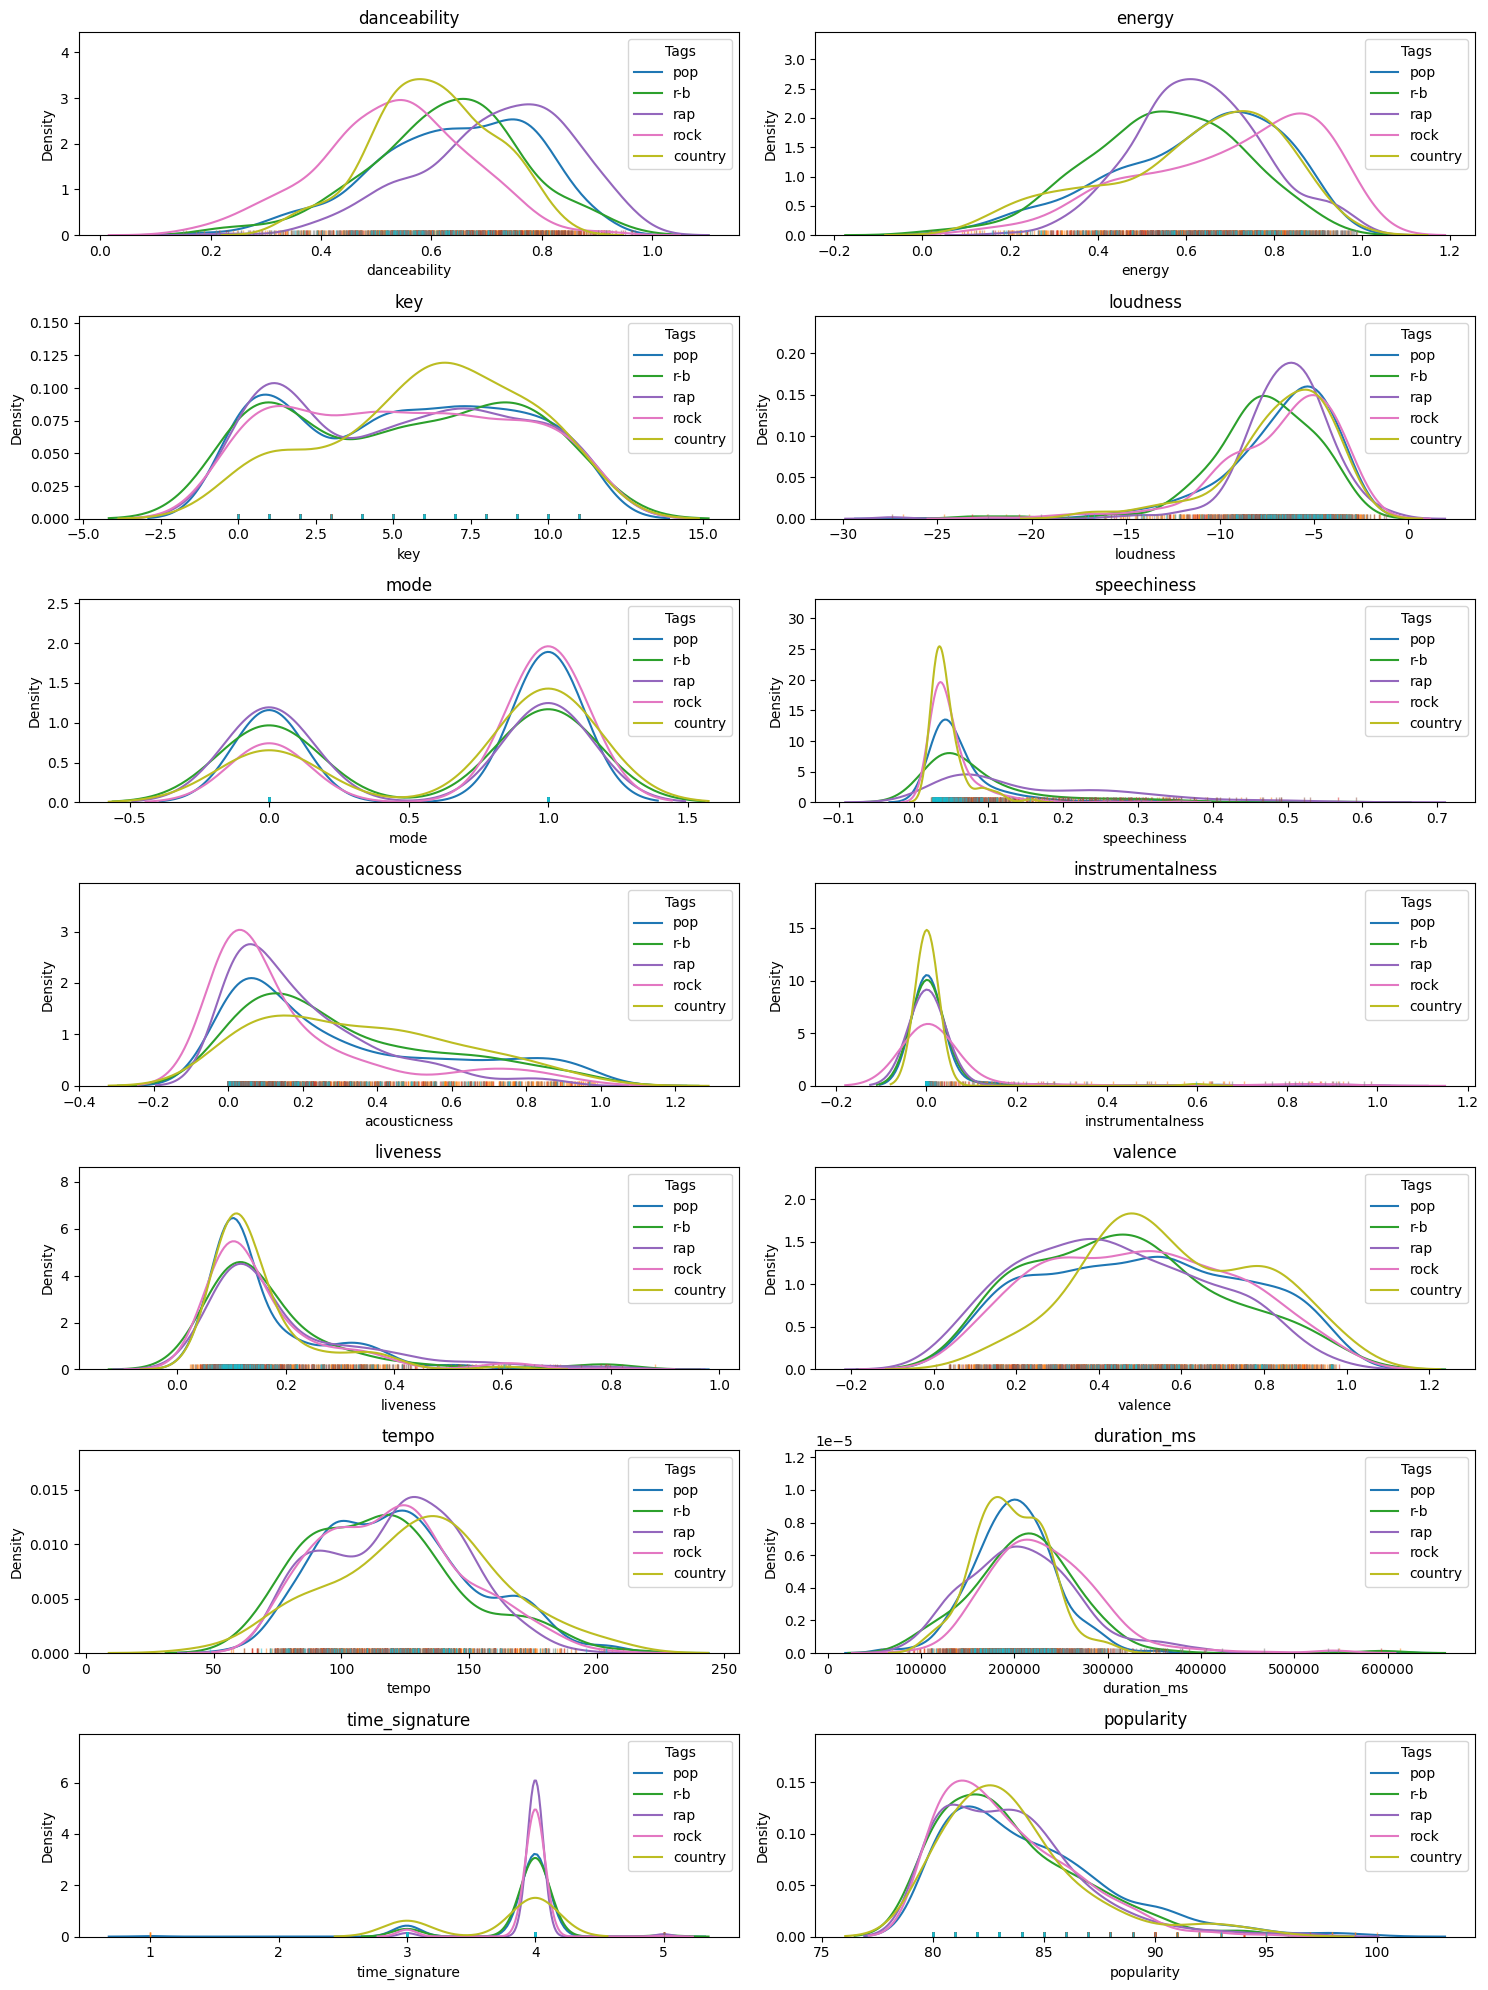

In [152]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['genius_id', 'released_year']]
fig, axs = plt.subplots(7,2, figsize=(15,20))
axs = axs.flatten()
for i, col in enumerate(numerical_cols):
    for tag in df['tags'].unique():
        sns.kdeplot(x=df[df['tags'] == tag][col], label=tag, ax=axs[i])
        sns.rugplot(x=df[df['tags'] == tag][col], alpha=0.5, ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel(col)
    axs[i].legend(title='Tags')

plt.tight_layout()
plt.show()

In [164]:
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
df[audio_features].describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,0.264027,0.632352,0.629378,0.031360,0.174145,0.085655,121.948897,0.495879
std,0.273744,0.150625,0.189924,0.134112,0.132101,0.086622,28.914980,0.239037
min,0.000008,0.150000,0.016700,0.000000,0.023200,0.022700,48.718000,0.006720
25%,0.040600,0.531000,0.504000,0.000000,0.095800,0.035800,98.721000,0.304000
50%,0.166000,0.639000,0.650000,0.000003,0.119000,0.051200,121.075000,0.489000
75%,0.422000,0.748000,0.772000,0.000289,0.206000,0.090800,140.061000,0.684000
max,0.989000,0.969000,0.990000,0.987000,0.881000,0.591000,210.164000,0.981000


[ 0.14293982  0.06212731 -0.04527959 -0.0024054  -0.05011202 -0.1515804
  0.03404744  0.0627473   0.14293982]
[ 0.17258055 -0.04407402 -0.41385524 -0.08446297  0.05398122  0.05103151
 -0.18753486 -0.11651618  0.17258055]
[-0.24513041  0.56822548  0.01589991 -0.06364657  0.21893444  0.88487438
 -0.02525362 -0.23392316 -0.24513041]
[-0.33852146 -0.68256064  0.36338158  0.17892468 -0.06502417 -0.39002079
 -0.05555989  0.01755324 -0.33852146]
[ 0.32665203 -0.19918058 -0.09691862 -0.17644164 -0.1697394  -0.46032462
  0.26366372  0.35359359  0.32665203]


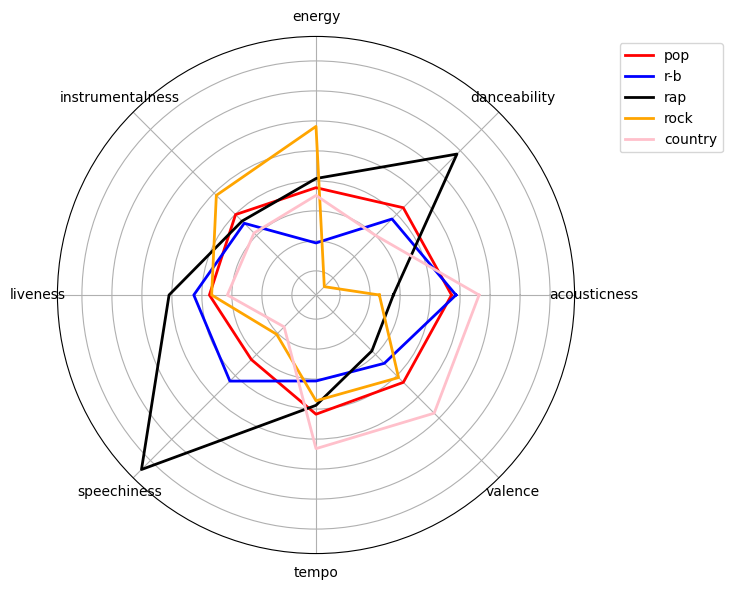

In [172]:
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
df_plot = df[audio_features].copy()
tags = df['tags'].unique()

scaler = StandardScaler()
df_plot = scaler.fit_transform(df_plot)
df_plot = pd.DataFrame(df_plot, columns=audio_features)
df_plot['tags'] = df['tags']

data_values = []
for tag in tags:
    tag_data = df_plot[df_plot['tags'] == tag][audio_features].mean().values.tolist()
    data_values.append(tag_data)

data_values = np.array(data_values)

angles = np.linspace(0, 2 * np.pi, len(audio_features), endpoint=False).tolist()
angles += angles[:1]

custom_colors = ['red', 'blue', 'black', 'orange', 'pink']
tag_color_map = {tag: color for tag, color in zip(tags, custom_colors)}

fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(8, 6))

for i, values in enumerate(data_values):
    values = np.concatenate((values, [values[0]]))
    print(values)
    tag = tags[i]
    color = tag_color_map[tag]
    ax.plot(angles, values, linestyle='-', linewidth=2, color=color, label=tag)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(audio_features)
ax.set_yticklabels([])
ax.grid(True)
ax.legend(tags, loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

# Biểu diễn các cột dạng category:

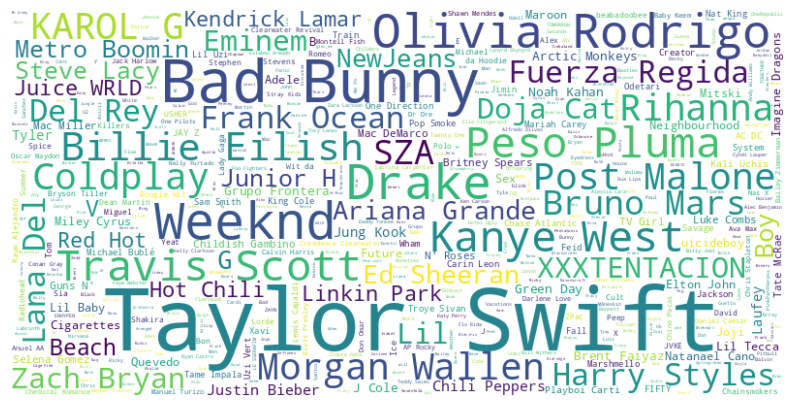

In [73]:
artists = ' '.join(df['artist_name'])
wordcloud = WordCloud(width=800, height=400, max_words=500, background_color='white').generate(artists)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nhìn chung, trong các track có popularity cao trong data thu thập được, số lượng track được sáng tác nhiều nhất thuộc về những cái tên nổi tiếng như Taylor Swift, Olivia Rodrigo, Bad Bunny, Drake, Kanye West,...

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = s
wordcloud = WordCloud(background_color="black",max_words=len(s),random_state=0,max_font_size=256).generate(text)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## II. Phân tích dữ liệu:

# Câu hỏi 1: Số lượng nhạc và phân bố của các bài nhạc theo các năm

## Ta sẽ xem dữ liệu của ta phân bổ thế nào qua từng thập niên:

In [ ]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade


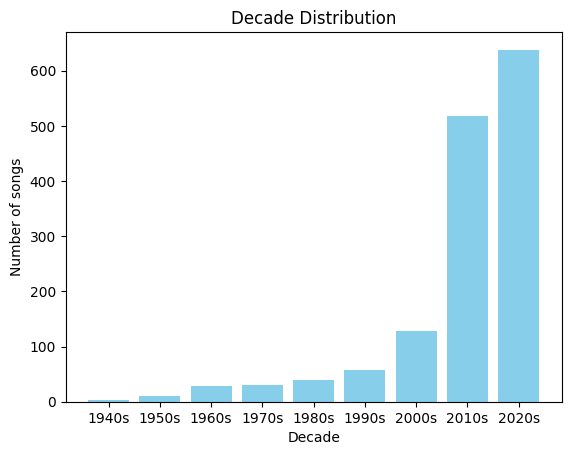

In [ ]:
decade = df['released_year'].apply(lambda x : get_decade(x))
decade_index = decade.value_counts().index[::-1]
decade_value = decade.value_counts().values[::-1]

# Create a bar plot
plt.bar(decade_index, decade_value, color='skyblue')
plt.xlabel('Decade')
plt.ylabel('Number of songs')
plt.title('Decade Distribution')
plt.show()

**Nhận xét:** Có thể thấy dữ liệu của ta phân bố trong 2 thập niên gần đây

## Ta sẽ xem dữ liệu của ta phân bố thế nào qua từng năm trong 2 thập niên gần nhất 2010s và 2020s

In [ ]:
df_2010_2023 = df[df['released_year'] >= 2010]
songs_2010_2023 = df_2010_2023['released_year'].value_counts().sort_index()

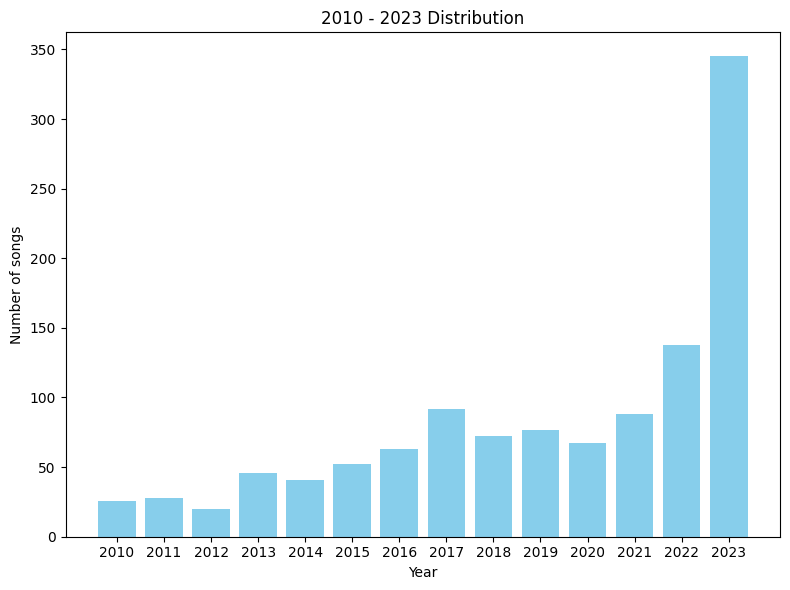

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(songs_2010_2023.index,songs_2010_2023.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of songs')
plt.title('2010 - 2023 Distribution')
plt.xticks(songs_2010_2023.index)
plt.tight_layout()
plt.show()

**Thể loại thịnh hành từ 2010 - 2023**

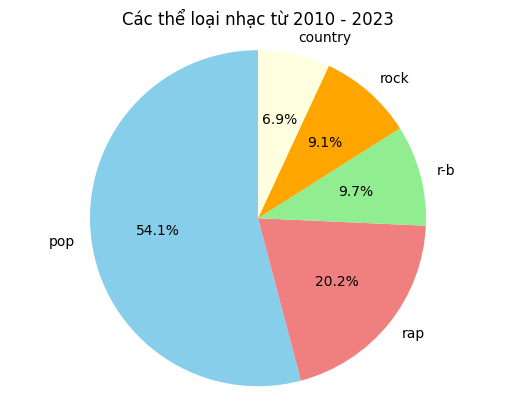

In [ ]:
tags_2010_2023 = df_2010_2023['tags']
tags_count = tags_2010_2023.value_counts()
plt.pie(tags_count.values, labels=tags_count.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'lightyellow'])
plt.axis('equal')

plt.title('Các thể loại nhạc từ 2010 - 2023')
plt.show()

#Câu hỏi 2: Tương quan giữa các thuộc tính nhạc

Ta có tổng 13 thuộc tính của một bài nhạc như bên dưới

In [ ]:
song_features = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']]

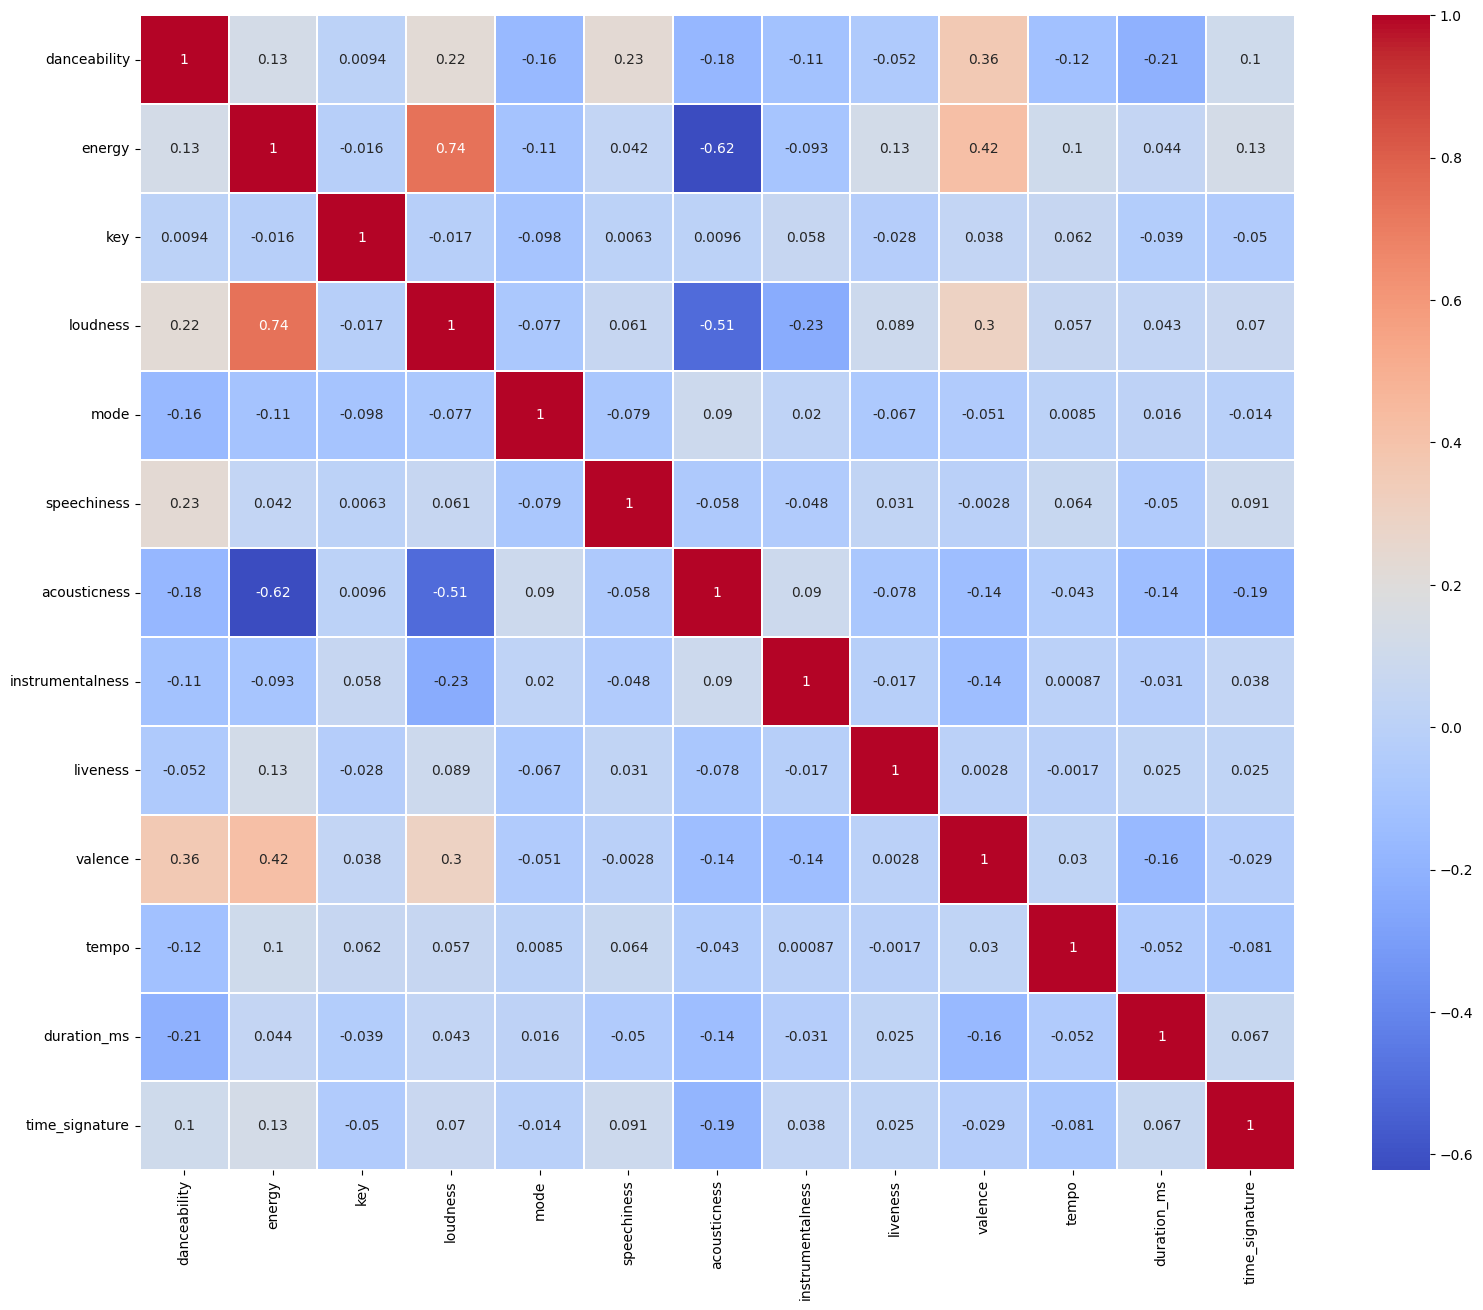

In [ ]:
corr = song_features.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr,cmap = 'coolwarm',square = True ,linewidth = 0.2, linecolor = 'white',annot = True)
plt.show()

## Câu hỏi 3: Thời lượng của các bài nhạc qua từng năm
- Trả lời cho việc : Xu hướng nghe nhạc của mọi người. Họ thích loại âm nhạc ngắn, nhanh hay dài dòng.

- Cách để tìm ra câu trả lời : Gom nhóm các bài hát lại theo dữ liệu từng năm, lấy dữ liệu duration_ms sau đó tính trung bình để đưa ra giá trị cần tìm. Với từng thể loại, sau khi gom nhóm theo năm, ta xét từng thể loại trong năm đó để đưa ra kết quả mong muốn.

**Thời lượng bài hát của tất cả các thể loại trong từng năm**

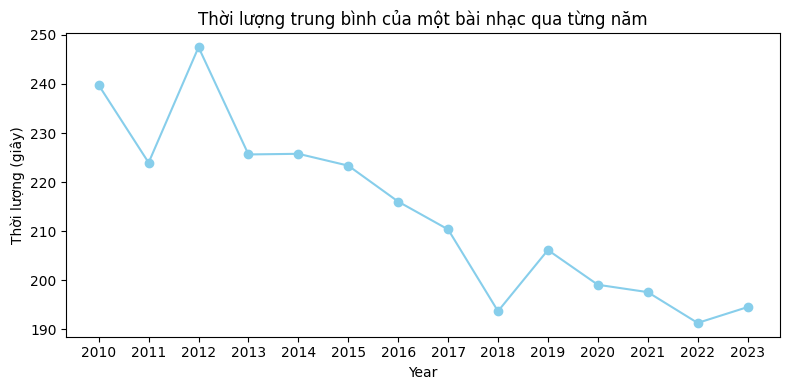

In [ ]:
duration_per_year = df_2010_2023.groupby(['released_year'])['duration_ms'].mean()/1000
plt.figure(figsize = (8,4))
plt.plot(duration_per_year.index, duration_per_year.values, marker = 'o', color = 'skyblue')
plt.xlabel('Year')
plt.ylabel('Thời lượng (giây)')
plt.title('Thời lượng trung bình của một bài nhạc qua từng năm')
plt.xticks(duration_per_year.index)
plt.tight_layout()
plt.show()

**Thời lượng của từng thể loại nhạc qua từng năm**

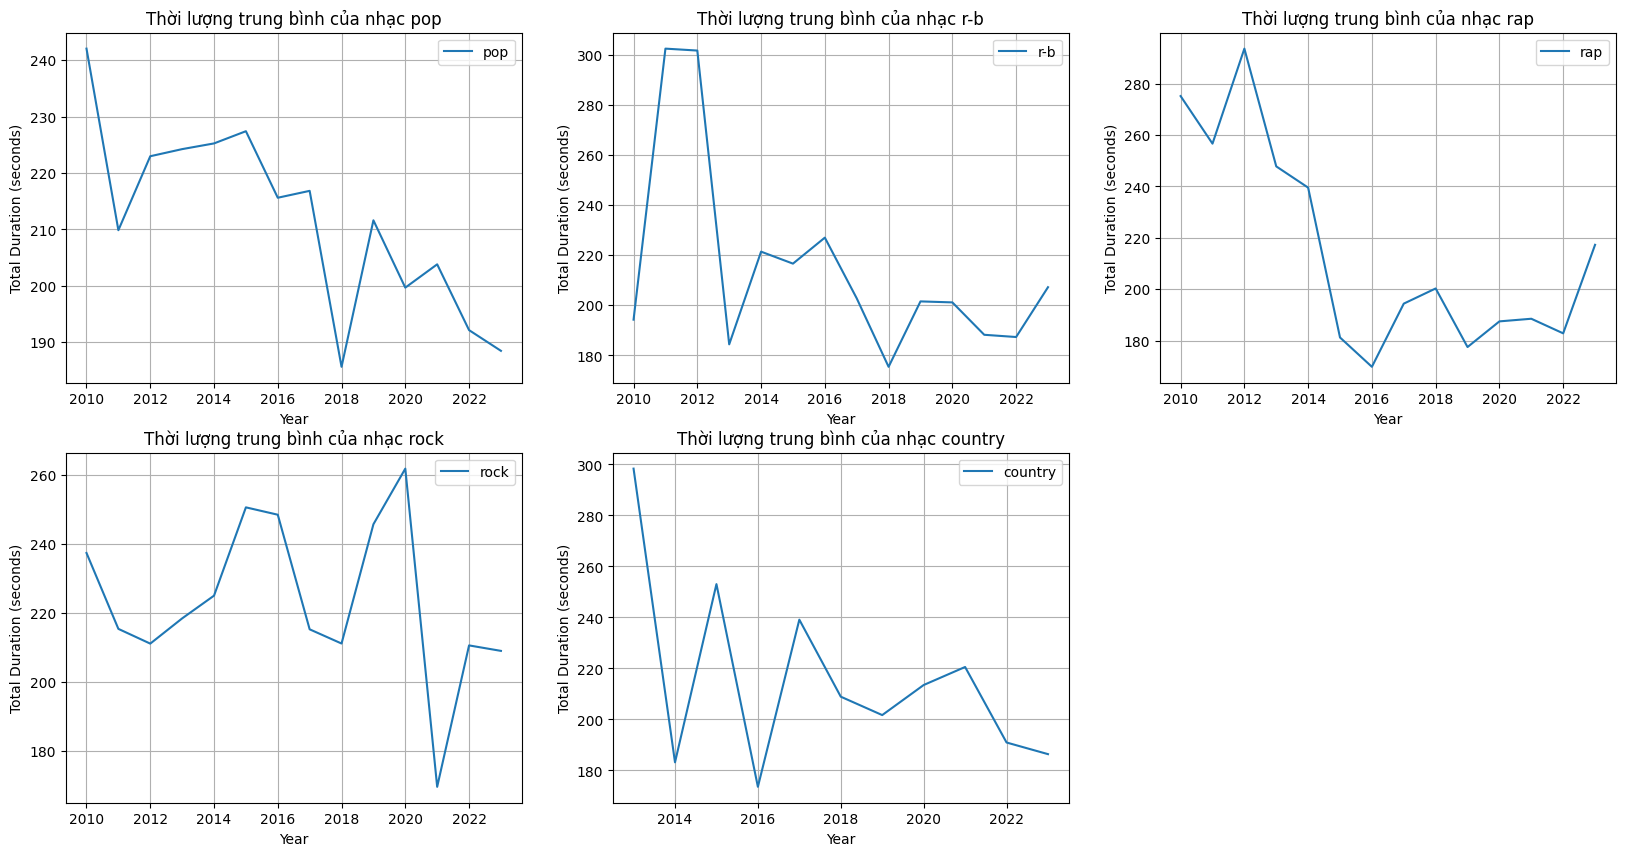

<Figure size 1000x400 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
plt.figure(figsize =(10,4))
for i,genre in enumerate(df['tags'].unique()):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    genre_data = df_2010_2023[df_2010_2023['tags'] == genre].groupby('released_year')['duration_ms'].mean()/1000
    ax.plot(genre_data.index, genre_data.values, label=genre)

    ax.set_xlabel('Year')
    ax.set_ylabel('Total Duration (seconds)')
    ax.set_title(f'Thời lượng trung bình của nhạc {genre}')
    ax.legend()
    ax.grid(True)

axes.flatten()[5].axis('off')
plt.tight_layout()
plt.show()

**Nhận xét:**
Có thể thấy, xu hướng về thời lượng của bài hát là giảm dần. Việc này có nhiều nguyên nhân xuất phát bởi thị trường âm nhạc:
- Thời lượng ngắn dễ tiếp cận với người nghe và quảng bá. Việc có thời lượng ngắn giúp việc quảng bá những đoạn hay nhất cho người nghe trở nên dễ hơn.
- Tăng lượt nghe : Một bài nhạc ngắn sẽ giúp cho việc stream nhạc (tức nghe lại nhiều lần) trở nên dễ hơn và tiết kiệm thời gian hơn. Từ đó, giúp cho thành tích của tác phẩm âm nhạc trên nền tảng số Spotify được cải thiện.

## Câu hỏi 4: Các đặc trưng về độ sôi động của bài nhạc.
Trả lời cho việc: Mỗi thể loại nhạc thì mang những đặc trưng gì. Ví dụ, nhạc Rock thì mạnh mẽ, ồn ào. Nhạc Country thì thường được nhận xét là du dương, nhẹ nhàng.
Cách tìm câu trả lời : Ta sẽ xét dựa trên thông số loudness và energy. Có thể sử dụng biểu đồ cột để cho thấy trung bình và boxplot để biểu diễn cụ thể cho từng thể loại nhạc.

Vì độ đo của loudness (tiếng ồn) là một độ đo logarit, và được quy định 0 là âm thanh to nhất và mức ổn định cao nhất trước khi âm thu bị nhiễu. Trong dữ liệu, loudness có giá trị từ -60 đến 0 dB.

In [ ]:
energy_loudness = df[['loudness','energy','tags']]
energy_loudness.groupby('tags').mean()

,loudness,energy
tags,,
country,-6.865512,0.610977
pop,-6.841020,0.620781
r-b,-7.717015,0.550804
rap,-6.476207,0.632396
rock,-6.856173,0.698369


#Câu hỏi 5: Phân cụm các nghệ sĩ theo từng thể loại?

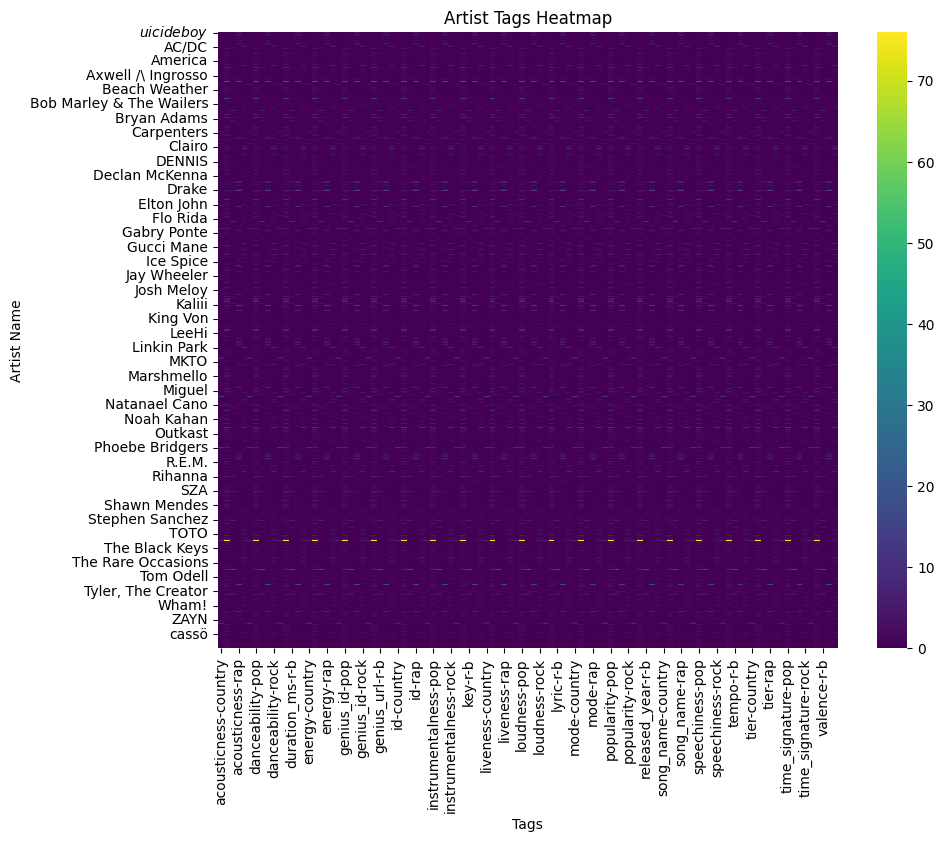

In [179]:
pivot_df = df.pivot_table(index='artist_name', columns='tags', aggfunc=len, fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_df, cmap='viridis')
plt.xlabel('Tags')
plt.ylabel('Artist Name')
plt.title('Artist Tags Heatmap')
plt.show()

#Sườn bài

- Phân bố của từng cột. Box plot.
- year : Vẽ histogram (Lấy decade).
- Thuộc tính nhạc : Vẽ boxplot.


Artist : Vẽ biểu đồ tròn.

Câu hỏi 1: Sự tương quan giữa các nhóm thuộc tính nhạc?

Câu hỏi 2: Thể loại nhạc phổ biến theo từng thời kì?

Câu hỏi trả lời cho việc xu hướng nhạc của cộng đồng thay đổi theo từng mốc thời gian?

Câu hỏi 3: Thời lượng trung bình của các thể loại nhạc?

Câu hỏi trả lời cho việc một thể loại nhạc mang những đặc trưng nào?

Câu hỏi 4: energy, tempo, danceability của nhạc theo từng tags.

Câu hỏi 5: Beat nền instrumentalness, acousticness và speechiness.

Câu hỏi 6: Phân cụm các nghệ sĩ theo từng thể loại?







